In [20]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [21]:
# 数据扩充和规范化训练
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 随机长宽比裁剪
        transforms.RandomHorizontalFlip(),  # 依概率p水平翻转 无填充
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),      # 先resize再CenterCrop后可以得到一个不怎么会拉伸变形又包含大部分图像信息的正方形图片
        transforms.CenterCrop(224),  # 将图片从中心裁剪成224*224
        transforms.ToTensor(),       # 转换成为再张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 标准化参数：各通道均值；各通道标准差
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../ResNet18_finetune/weibo'

# datasets.ImageFolder利用构造图片数据加载器
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
# 生成dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                            batch_size=5,
                                            shuffle=True,
                                            num_workers=2
                                            )
              for x in ['train', 'val','test']}
# dataset的大小
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

class_names = image_datasets['train'].classes  # ImageFolder.classes储存了类别名称

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 将图片写入tensorboard

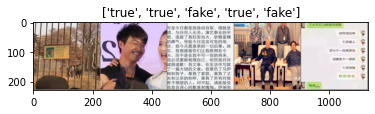

In [22]:
# tensor to image to tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fanshion_mnist_experiment_3')

def imshow(inp, title=None):
    """for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # 将inp截取到0，1之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 稍作停顿，以便更新图表


# 读了一个batch的图像和类别
inputs, classes = next(iter(dataloaders['train']))

# 做一个grid
img_grid = torchvision.utils.make_grid(inputs)

# tensor to image
imshow(img_grid, title=[class_names[x] for x in classes])

# 写入tensorboard 
'''存在问题：读入图片的颜色不对；不过plt能显示正确'''
writer.add_image('five_weibo_images', img_grid)

## 训练模型

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range (num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('——' * 20)

        # 每个epoch的训练、验证[阶段]
        for phase in ['train', 'val']:

            # 训练
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corr = 0

            #迭代
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 选择阶段
                with torch.set_grad_enabled(phase == 'train'):  # 训练时固定模型，禁止梯度传播，默认false
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # _:占位符
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)  # inputs.size(0)就是batch_size 将loss视作batch中每一个样本的loss，所以算总loss需要倍乘
                running_corr += torch.sum(preds == labels.data)  # 一个batch中的正确个数

            if phase == 'train':
                scheduler.step()  # 每个epoch学习率调整
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corr.double() / dataset_sizes[phase]

            writer.add_scalar('epoch_loss', epoch_loss, epoch * dataset_sizes[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 验证
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    # 训练时长
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #加载最佳权重，返回模型
    model.load_state_dict(best_model_wts)
    return model

## 测试模型

In [22]:
def test_model(model, criterion, phase = 'test'):
    print('testing model')
    test_loss = 0.0
    test_corr = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_loss = criterion(outputs, labels)
            test_corr += torch.sum(preds == labels.data)
    
    test_loss /= dataset_sizes[phase]
    test_corr = test_corr.double()/dataset_sizes[phase]
    print(f"Test Erorr: \n Acc:{(100*test_corr):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 加载预训练模型并重置最终的全连接层

In [24]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# 直接在resnet18预训练模型后加fc层，设置输出大小为2，二分类
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epoch进行一次衰减
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 训练 & 验证 & 测试

In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
————————————————————————————————————————


/Users/zhongshannan/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.7738 Acc: 0.5567
val Loss: 0.7135 Acc: 0.6100

Epoch 2/25
————————————————————————————————————————
train Loss: 0.7279 Acc: 0.6100
val Loss: 1.1017 Acc: 0.5500

Epoch 3/25
————————————————————————————————————————


KeyboardInterrupt: 

In [ ]:
test_model(model_ft, criterion)

## 固定预训练模型,只训练最后一层

In [23]:
# 冻结除最后一层之外的所有网络
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新模块参数模型默认为requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# 只复制最后一层conv
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 只优化最后一层的参数
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 每7个epoch进行一次衰减
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


## 训练 & 验证 & 测试

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)